In [33]:
import numpy as np
import sympy as sp
from PIL import Image
from scipy import interpolate
import matplotlib.pyplot as plt
import time
from skimage.metrics import structural_similarity as s_sim
from skimage import img_as_float

# Tarea 3:Interpolación Bicúbica

## Instrucciones

* La tarea es individual.
* Las consultas sobre las tareas se deben realizar por medio de la plataforma Aula.
* La tarea debe ser realizada en `Jupyter Notebook` (`Python3`).
* Se evaluará la correcta utilización de librerias `NumPy`, `SciPy`, entre otras, así como la correcta implementación de algoritmos de forma vectorizada.
*  **El archivo de entrega debe denominarse ROL-tarea-numero.ipynb**. _De no respetarse este formato existirá un descuento de **50 puntos**_
* La fecha de entrega es el viernes 24 de Julio a las **18:00 hrs**.  Se aceptarán entregas hasta las 19:00 hrs sin descuento en caso de existir algun problema, posteriormente existirá un descuento lineal hasta las 20:00 hrs del mismo día.
* Las tareas que sean entregadas antes del jueves a mediodía recibirán una bonificación de 10 puntos
* Debe citar cualquier código ajeno utilizado (incluso si proviene de los Jupyter Notebooks del curso).


## Introducción

En la siguiente tarea estudiaremos un método de interpolación denominado **Interpolación Bicúbica**, utilizada frecuentemente sobre imágenes. Aplicaremos el método para aumentar la resolución de una imagen intentando preservar las propiedades de la versión original.

## Contexto

Supongamos que usted conoce $f$ y las derivadas $f_x$, $f_y$ y $f_{xy}$ dentro de las coordenadas $(0,0),(0,1),(1,0)$ y $(1,1)$ de un cuadrado unitario. La superficie que interpola estos 4 puntos es:

$$
p(x,y) = \sum\limits_{i=0}^3 \sum_{j=0}^3 a_{ij} x^i y^j.
$$

Como se puede observar el problema de interpolación se resume en determinar los 16 coeficientes $a_{ij}$ y para esto se genera un total de $16$ ecuaciones utilizando los valores conocidos de $f$,$f_x$,$f_y$ y $f_{xy}$. Por ejemplo, las primeras $4$ ecuaciones son:

$$
\begin{aligned}
f(0,0)&=p(0,0)=a_{00},\\
f(1,0)&=p(1,0)=a_{00}+a_{10}+a_{20}+a_{30},\\
f(0,1)&=p(0,1)=a_{00}+a_{01}+a_{02}+a_{03},\\
f(1,1)&=p(1,1)=\textstyle \sum \limits _{i=0}^{3}\sum \limits _{j=0}^{3}a_{ij}.
\end{aligned}
$$

Para las $12$ ecuaciones restantes se debe utilizar:

$$
\begin{aligned}
f_{x}(x,y)&=p_{x}(x,y)=\textstyle \sum \limits _{i=1}^{3}\sum \limits _{j=0}^{3}a_{ij}ix^{i-1}y^{j},\\
f_{y}(x,y)&=p_{y}(x,y)=\textstyle \sum \limits _{i=0}^{3}\sum \limits _{j=1}^{3}a_{ij}x^{i}jy^{j-1},\\
f_{xy}(x,y)&=p_{xy}(x,y)=\textstyle \sum \limits _{i=1}^{3}\sum \limits _{j=1}^{3}a_{ij}ix^{i-1}jy^{j-1}.
\end{aligned}
$$


Una vez planteadas las ecuaciones, los coeficientes se pueden obtener al resolver el problema $A\alpha=x$, donde $\alpha=\left[\begin{smallmatrix}a_{00}&a_{10}&a_{20}&a_{30}&a_{01}&a_{11}&a_{21}&a_{31}&a_{02}&a_{12}&a_{22}&a_{32}&a_{03}&a_{13}&a_{23}&a_{33}\end{smallmatrix}\right]^T$ y ${\displaystyle x=\left[{\begin{smallmatrix}f(0,0)&f(1,0)&f(0,1)&f(1,1)&f_{x}(0,0)&f_{x}(1,0)&f_{x}(0,1)&f_{x}(1,1)&f_{y}(0,0)&f_{y}(1,0)&f_{y}(0,1)&f_{y}(1,1)&f_{xy}(0,0)&f_{xy}(1,0)&f_{xy}(0,1)&f_{xy}(1,1)\end{smallmatrix}}\right]^{T}}$.


En un contexto más aplicado, podemos hacer uso de la interpolación bicúbica para aumentar la resolución de una imagen. Supongamos que tenemos la siguiente imagen de tamaño $5 \times 5$:

<img src="img1.png" width="20%"/>

Podemos ir tomando segmentos de la imagen de tamaño $2 \times 2$ de la siguiente forma:

<img src="img2.png" width="50%"/>

Por cada segmento podemos generar una superficie interpoladora mediante el algoritmo de interpolación cubica. Para el ejemplo anterior estariamos generando $16$ superficies interpoladoras distintas. La idea es hacer uso de estas superficies para estimar los valores de los pixeles correspondienets a una imagen más grande. Por ejemplo, la imagen $5 \times 5$ la podemos convertir a una imagen de $9 \times 9$ agregando un pixel entre cada par de pixeles originales además de uno en el centro para que no quede un hueco.

<img src="img3.png" width="50%"/>

Aca los pixeles verdes son los mismos que la imagen original y los azules son obtenidos de evaluar cada superficie interpoladora. Notar que existen pixeles azules que se pueden obtener a partir de dos superficies interpoladoras distintas, en esos casos se puede promediar el valor de los pixeles o simplemente dejar uno de los dos. 

Para trabajar con la interpolación bicubica necesitamos conocer los valores de $f_x$, $f_y$ y $f_{xy}$. En el caso de las imagenes solo tenemos acceso al valor de cada pixel por lo que deberemos estimar cual es el valor de estos. Para estimar $f_x$ haremos lo siguiente:

Para estimar el valor de $f_x$ en cada pixel haremos una interpolación con los algoritmos conocidos, usando tres pixels en dirección de las filas, luego derivaremos el polinomio obtenido y finalmente evaluaremos en la posición de interes. La misma idea aplica para $f_y$ solo que ahora interpolaremos en dirección de las columnas.

<img src="img5.png" width="60%"/>

Por ejemplo si queremos obtener el valor de $f_x$ en la posición $(0,0)$ (imagen de la izquierda) entonces haremos una interpolación de Lagrange utilizando los pixeles $(0,0),(0,1)$ y $(0,2)$. Derivaremos el polinomio interpolador y evaluaremos en $(0,0)$. Por otro lado si queremos obtener el valor de $f_y$ en la posición $(0,0)$ (imagen de la derecha) entonces interpolaremos los pixeles $(0,0),(1,0)$ y $(2,0)$. Luego derivaremos el polinomio interpolador y evaluaremos en $(0,0)$.

Para obtener $f_{xy}$ seguiremos la idea anterior. Solo que esta vez se utilizaran los valores de $f_y$ y se interpolaran estos en dirección de las filas.

# Preguntas

## 1. Interpolación bicubica

### 1.1  Obtener derivadas (30 puntos)

Implemente la función `derivativeValues` que reciba como input un arreglo con valores, el método de interpolación y si es que se considera el uso de  los puntos de chebyshev . La función debe retornar un arreglo de igual dimensión con los valores de las derivadas de los puntos obtenidas

Los métodos de interpolación serán representados por los siguientes valores

* Interpolación de lagrange: `'lagrange'`
* Diferencias divididas de Newton: `'newton'`
* Spline cubica: `'spline3'`


In [34]:
# codigo de https://github.com/sct-utfsm/INF-285/blob/master/material/05_interpolacion_1D/interpolacion.ipynb
def chebyshevNodes(n):
    """
    Parameters
    ----------
    n: (int) size of array with chebyshev nodes

    Returns
    -------
    array with chebyshev nodes
    """
    i = np.arange(1, n+1)
    t = (2*i - 1) * np.pi / (2 * n)
    return np.cos(t)


# codigo de https://github.com/tclaudioe/Scientific-Computing/blob/master/SC1/07_Polynomial_Interpolation_1D.ipynb
def Divided_Differences(x, y):
    dd = np.array([y])
    for i in range(len(x)-1):
        ddi = []
        for a in range(len(x)-i-1):
            ddi.append((dd[i][a+1]-dd[i][a])/(x[a+i+1]-x[a]))
        ddi = np.append(ddi,np.full((len(x)-len(ddi),),0.0))
        dd = np.append(dd,[ddi],axis=0)
    return np.array(dd)


def Newton(x, y, show=False):
    # We calculate the divided differences and store them in a data structure
    dd = Divided_Differences(x,y)
    
    # The function shows the data if the flag is true

    #if show:
    #print('Data Points: '); print([(x[i],y[i]) for i in range(len(x))])
    xS = sp.Symbol('x')
    N = np.dot(dd[:,0],np.append([1],[np.prod(xS-x[:i]) for i in range(1,len(dd))]))
    #print('Interpolation Function: ');
    #print(N)
        
    # Finally, we return a data structure with our interpolating polynomial
    D = {'M':'Newton',
         'P':dd[:,0],
         'x':x,
         'y':y,
         'N':N}
    return D

In [35]:
def derivativeValues(values, method, cheb):
    """
    Parameters
    ----------
    values:	(int array) points values
    method:	(string)	interpolation method
    cheb:	(boolean)	if chebyshev points are used

    Returns
    -------
    d:	(float array) derivative value of interpolated points

    """
    var, y = sp.symbols('x y')
    
    if cheb:
        x = np.sort(chebyshevNodes(values.shape[0]))
        
    else:
        x = np.linspace(0, 1, num=values.shape[0])
        
    if method == 'lagrange':
        d = interpolate.lagrange(x, values)
        d = np.poly1d(d).deriv()
        
    elif method == 'newton':
        D = Newton(x, values)
        d = D["N"]
        d = sp.diff(d, var)
        
    else:
        d = interpolate.CubicSpline(x, values)
        d = d.derivative()
        
    if method == 'newton':
        d = np.array([d.subs({"x":i}) for i in x]).astype(int)
    else:
        d = d(x)
    
    return d


### 1.2 Interpolación de imagen (50 puntos)
Implemente la función `bicubicInterpolation` que reciba como input la matriz de la imagen y cuantos píxeles extra se quiere agregar entre los píxeles originales y el algoritmo de interpolación a utilizar. La función debe retornar la matriz con la imagen de dimensión nueva. Considere que se debe aplicar el método de interpolación en cada canal RGB por separado.

In [36]:
def interP(Aoriginal, Anew, n, method, cheb, interiorPixels):
    """
    Parameters
    ----------
    Aoriginal:	    (n x n x 1 array) RGB channel
    Anew:	        (m x m x 1 array) Aoriginal after resizing
    n:	            (int)             range
    method:         (string)          method for interpolation
    cheb:           (boolean)         in case we need chebyshev nodes
    interiorPixels: (int)             quantity of new pixels in between
    Returns
    -------
    A:	(float array) resized and interpolated matrix (Anew)

    """    
    # this is for alpha = l x F x l.T multiplication   
    l = np.array([
        [1,0,0,0],
        [0,0,1,0],
        [-3,3,-2,-1],
        [2,-2,2,1]
    ])

    # function to obtain interpolation of an x,y point w/  alpha coef
    P = lambda x,y,a: np.array([x**i for i in range(4)])@ a @np.array([y**i for i in range(4)])
    
    A = Anew.copy()
    
    # we prepare derivatives matrices
    fx_Matrix = np.zeros_like(Aoriginal)
    fy_Matrix_T = np.zeros_like(Aoriginal)    
    fxy_Matrix = np.zeros_like(Aoriginal)
         
    for i,x in enumerate(Aoriginal):
        for j,y in enumerate(x):
            if j+2 < n:
                fx_Matrix[i,j: j+3] = derivativeValues(Aoriginal[i, j:j+3], method,cheb)
                fy_Matrix_T[i,j: j+3] = derivativeValues(Aoriginal.T[i, j:j+3], method,cheb)
            else:
                break
                
    fy_Matrix = fy_Matrix_T.T
    
    for i,x in enumerate(fy_Matrix):
        for j,y in enumerate(x):
            if j+2 < n:
                fxy_Matrix[i,j: j+3] = derivativeValues(fy_Matrix[i, j:j+3], method,cheb)
            else:
                break
                
    #-----------------------------------------------------------------> hasta acá ok    
    #-----------------------------------------------------------------> 
    
    for ii, x in enumerate(Anew):
        for jj, y in enumerate(x):
            
            newI = np.floor(ii/(1+interiorPixels)).astype(int)
            newJ = np.floor(jj/(1+interiorPixels)).astype(int)
            
            if newI + 1 < n:
                if newJ + 1 < n:
                    f00 = Aoriginal[newI, newJ]
                    f01 = Aoriginal[newI, newJ+1]
                    f10 = Aoriginal[newI+1, newJ]
                    f11 = Aoriginal[newI+1, newJ+1]

                    fx00 = fx_Matrix[newI, newJ]
                    fx01 = fx_Matrix[newI, newJ+1]
                    fx10 = fx_Matrix[newI+1, newJ]
                    fx11 = fx_Matrix[newI+1, newJ+1]

                    fy00 = fy_Matrix[newI, newJ]
                    fy01 = fy_Matrix[newI, newJ+1]
                    fy10 = fy_Matrix[newI+1, newJ]
                    fy11 = fy_Matrix[newI+1, newJ+1]

                    fxy00 = fxy_Matrix[newI, newJ]
                    fxy01 = fxy_Matrix[newI, newJ+1]
                    fxy10 = fxy_Matrix[newI+1, newJ]
                    fxy11 = fxy_Matrix[newI+1, newJ+1]
                
                else:
                    
                    f00 = f01 = Aoriginal[newI, newJ]
                    f10 = f11 = Aoriginal[newI+1, newJ]

                    fx00 = fx01 = fx_Matrix[newI, newJ]
                    fx10 = fx11 = fx_Matrix[newI+1, newJ]
                    
                    fy00 = fy01 = fy_Matrix[newI, newJ]
                    fy10 = fy11 = fy_Matrix[newI+1, newJ]
                    
                    fxy00 = fxy01 = fxy_Matrix[newI, newJ]
                    fxy10 = fxy11 = fxy_Matrix[newI+1, newJ]
            else:
                if newJ + 1 < n:
                    f00 = f10 = Aoriginal[newI, newJ]
                    f01 = f11 = Aoriginal[newI, newJ+1]

                    fx00 = fx10 = fx_Matrix[newI, newJ]
                    fx01 = fx11 = fx_Matrix[newI, newJ+1]
                    
                    fy00 = fy10 = fy_Matrix[newI, newJ]
                    fy01 = fy11 = fy_Matrix[newI, newJ+1]
                    
                    fxy00 = fxy10 = fxy_Matrix[newI, newJ]
                    fxy01 = fxy11 = fxy_Matrix[newI, newJ+1]  
            #----------------------------------------------------------------------- desde aca
            #final stuff to get te interpolated point  
            # we got the super F
            # compute coeficients
            
            F = np.array([
                [f00,f01,fy00,fy01],
                [f10, f11, fy10,fy11],
                [fx00,fx01,fxy00,fxy01],
                [fx10,fx11,fxy10,fxy11]])
            
            # big brain time
            a = l @ F @ l.T
            #----------------------------------------------------------------------- hasta acá ok
            
            # calculate interpolated point
            H = ((ii - np.floor(newI*(1+interiorPixels)))/n - 1)
            V = ((jj - np.floor(newJ*(1+interiorPixels)))/n - 1)
            
            #bruh moment
            p = P(1+H, 1+V, a)
            if 0 <= p:
                if p <= 255:
                    A[ii,jj] = p
                else:
                    A[ii,jj] = 255
            else:
                A[ii,jj] = 0             
    return A            

In [37]:
def bicubicInterpolation(image, interiorPixels, method, cheb):
    """
    Parameters
    ----------
    image:	(nxnx3 array) image array in RGB format
    interiorPixels:	(int)	pixels for expansion
    method:	(string)	interpolation method
    cheb:	(boolean)	if chebyshev points are used

    Returns
    -------
    newImage:	(nxnx3 array) image array in RGB format

    """
    # original image decomposition
    AR = image[0: , 0: , 0]
    AG = image[0: , 0: , 1]
    AB = image[0: , 0: , 2]   
    
    newN = image.shape[0] + interiorPixels*(image.shape[0] - 1)
    # new size array for each x in {R,G,B}
    newAR = np.zeros((newN, newN))
    newAG = np.zeros((newN, newN))
    newAB = np.zeros((newN, newN))   
    
    newAR = interP(AR, newAR, image.shape[0], method, cheb, interiorPixels)
    newAG = interP(AG, newAG, image.shape[0], method, cheb, interiorPixels)
    newAB = interP(AB, newAB, image.shape[0], method, cheb, interiorPixels)  
    
    # fill new matrices with values (just in case... just to be sure...)
    for i,x in enumerate(AR):
        for j,y in enumerate(x):
            newAR[i+i*interiorPixels, j+j*interiorPixels] = y
            newAG[i+i*interiorPixels, j+j*interiorPixels] = AG[i,j]
            newAB[i+i*interiorPixels, j+j*interiorPixels] = AB[i,j]

    newImage = np.zeros((newN,newN,3))
    newImage[0:,0:,0] = newAR.astype(np.uint8)
    newImage[0:,0:,1] = newAG.astype(np.uint8)
    newImage[0:,0:,2] = newAB.astype(np.uint8)
    
    return newImage.astype(np.uint8)

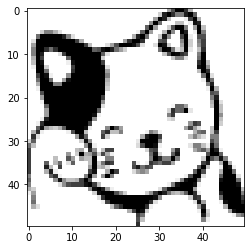

In [38]:
#Codigo para abrir y visualizar imágenes
img = Image.open('imagenes_prueba/cat.png')
img = img.convert('RGB')
array=np.array(img)
imgplot = plt.imshow(array)
plt.show()

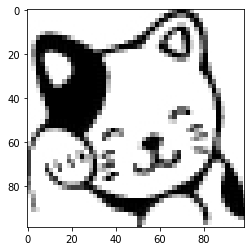

In [39]:
newImg = bicubicInterpolation(array, 1, "spline3", True)
imgplt = plt.imshow(newImg)
plt.show()

## 2. Evaluacion de algoritmos



### 2.1 Tiempo de ejecucion 
Implemente la funcion `timeInterpolation` que mida el tiempo de interpolacion de una imagen dado el algoritmo de interpolacion , en segundos.(5 puntos)

In [40]:
def timeInterpolation(image, interiorPixels, method,cheb):
    """
    Parameters
    ----------
    image:	(nxnx3 array) image array in RGB format
    interiorPixels:	(int)	interpolation method
    method:	(string)	interpolation method
    cheb:	(boolean)	if chebyshev points are used


    Returns
    -------
    total:	(float) time in seconds

    """
    t0 = time.time()
    bicubicInterpolation(image, interiorPixels, method, cheb)
    t1 = time.time()
    total = t1-t0
    
    return total

***Pregunta: ¿Cual es el metodo que presenta mayor velocidad en general? (5 puntos)***

In [41]:
timeInterpolation(array, 1, "spline3", True), timeInterpolation(array, 1, "spline3", False)

(10.028733968734741, 8.004606485366821)

In [42]:
timeInterpolation(array, 1, "lagrange", True), timeInterpolation(array, 1, "lagrange", False)

(12.369907140731812, 13.051870822906494)

In [43]:
timeInterpolation(array, 1, "newton", True), timeInterpolation(array, 1, "newton", False)

C:\Users\marth\anaconda3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: overflow encountered in ubyte_scalars


(60.67946124076843, 50.15962290763855)

##### RESPUESTA: El método que presenta mayor velocidad es el de splines cubicas.

### 2.2 Calculo de error
Implemente la funcion `errorInterpolation` la cual debe obtener el error de la imagen obtenida comparandola con una de referencia. El error debe ser calculado utilizando el indice SSIM (Structural similarity) (5 puntos)

In [ ]:
def errorInterpolation(original,new):
    """
    Parameters
    ----------
    image:	(nxn array) original image array in RGB format
    new:	(nxn array) new image array in RGB format obtained from interpolation


    Returns
    -------
    error:	(float) difference between images 

    """    
    error = 1 - s_sim(original, new, multichannel=True)
    return error

In [ ]:
#Codigo para abrir y visualizar imágenes
img = Image.open('imagenes_prueba/cat_1pixel.png')
img = img.convert('RGB')
im = img_as_float(img)

In [52]:
S_T = Image.fromarray(newImg, "RGB")

In [54]:
S_F = Image.fromarray(bicubicInterpolation(array, 1, "spline3", False), "RGB")

In [56]:
L_T = Image.fromarray(bicubicInterpolation(array, 1, "lagrange", True), "RGB")

In [59]:
L_F = Image.fromarray(bicubicInterpolation(array, 1, "lagrange", False), "RGB")

In [65]:
N_T = Image.fromarray(bicubicInterpolation(array, 1, "newton", True), "RGB")

C:\Users\marth\anaconda3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: overflow encountered in ubyte_scalars


In [63]:
N_F = Image.fromarray(bicubicInterpolation(array, 1, "newton", False), "RGB")

C:\Users\marth\anaconda3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: overflow encountered in ubyte_scalars


In [67]:
st = errorInterpolation(im, img_as_float(S_T))

In [68]:
sf = errorInterpolation(im, img_as_float(S_F))

In [69]:
lt = errorInterpolation(im, img_as_float(L_T))

In [70]:
lf = errorInterpolation(im, img_as_float(L_F))

In [71]:
nt = errorInterpolation(im, img_as_float(N_T))

In [72]:
nf = errorInterpolation(im, img_as_float(N_F))

***Pregunta: ¿Cual metodo presenta menor error? (5 puntos)***

In [75]:
np.sort([[st,"st"],[sf,"sf"],[lt,"lt"],[lf,"lf"],[nt,"nt"],[nf,"nf"]])

array([['0.20684577145988392', 'st'],
       ['0.20690862104470575', 'sf'],
       ['0.20684577145988392', 'lt'],
       ['0.20690862104470575', 'lf'],
       ['0.20694811256170598', 'nt'],
       ['0.20690862104470575', 'nf']], dtype='<U32')

#### El método que presenta menor error es el de Splines con nodos chebyshev

# Consideraciones

* Solo trabajaremos con imagenes cuadradas
* En el caso que el valor interpolado de un punto sea mayor a 255 o menor a 0, este se trunca a 255 o 0 respectivamente
* Esta permitido el uso de sympy para calcular derivadas y para construir el polinomio interpolador 
* El calculo de error puede ser calculado utilizando la imagen en escala de grises [(ejemplo)](https://scikit-image.org/docs/dev/auto_examples/transform/plot_ssim.html)